## Optimizing Dry Bean Sorting into Classes using Classification with K-nearest neighbors

In [5]:
# Download all the necessay libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("tableone")
library(tableone)
options(repr.matrix.max.rows = 6)



Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [6]:

# Read dataset

url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
bean_data <- read_csv(url)

# remove missing values if any
bean_data <- filter(bean_data, rowSums(is.na(bean_data)) != ncol(bean_data))




Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Spliting the data into training and testing set

In [7]:

#Set the seed. Don't remove this!
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of bean Classes in the dataset.

bean_split <- initial_split(bean_data, prop = 0.5, strata = Class)  
bean_train <- training(bean_split)   
bean_test <- testing(bean_split) # wont touch it until the best classifier is obtained

# your code here
bean_train
bean_test

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
47794,833.459,279.6546,217.9186,1.283298,0.6267232,48528,246.6844,0.7381313,0.9848747,0.8645991,0.8821041,0.005851248,0.002185283,0.7781077,0.9985444,BARBUNYA
47981,809.088,291.6540,210.0432,1.388543,0.6937880,48451,247.1666,0.7697775,0.9902995,0.9210594,0.8474651,0.006078530,0.001934041,0.7181971,0.9972476,BARBUNYA
49317,886.931,310.5631,202.4589,1.533956,0.7582971,50400,250.5840,0.7130856,0.9785119,0.7878197,0.8068700,0.006297282,0.001646445,0.6510392,0.9986656,BARBUNYA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57790,920.668,360.9603,204.7025,1.763341,0.8236453,58342,271.2573,0.7359815,0.9905385,0.8567546,0.7514878,0.006246069,0.001228780,0.5647338,0.9958183,SIRA
57944,921.449,353.8206,210.4090,1.681585,0.8039647,59041,271.6185,0.6863532,0.9814197,0.8575821,0.7676727,0.006106252,0.001308154,0.5893215,0.9909941,SIRA
58074,910.115,351.9589,210.4178,1.672667,0.8016096,58609,271.9230,0.7776483,0.9908717,0.8810470,0.7725988,0.006060524,0.001332006,0.5969089,0.9984295,SIRA


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42042,771.515,288.0827,186.3471,1.545947,0.7626149,42476,231.3645,0.8162544,0.9897825,0.8875738,0.8031185,0.006852259,0.001758458,0.6449992,0.9971345,DERMASON
42049,770.185,290.1634,185.0517,1.568013,0.7702435,42503,231.3838,0.7560050,0.9893184,0.8907902,0.7974258,0.006900602,0.001721186,0.6358878,0.9970802,DERMASON
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON


In [8]:
# Finding the number of observations in each Class 
num_of_classes <- bean_train|>
                    group_by(Class)|>
                    summarize(count = n())|>
                    arrange(count)
num_of_classes


Class,count
<chr>,<int>
BOMBAY,266
BARBUNYA,648
CALI,814
⋮,⋮
SEKER,1012
SIRA,1339
DERMASON,1762


# Variable Selection

Use of histograms to look at the distribtion of each variable
The variables with high overlapping are removed while the varibales with distinct classes are taken

The distribution is sistinct and therefore taken

 By observing the above histograms, we choose Area,Perimeter,AspectRation,Eccentricity,EquivDiameter,roundness,Compactness,ShapeFactor3 as variables as they have distinct values for classes .

Choosing the required variables by using select function

The data set has 7 classes and 8 variables to work on

Splitting of data set into trianing and testing

looking the percentage of each data set

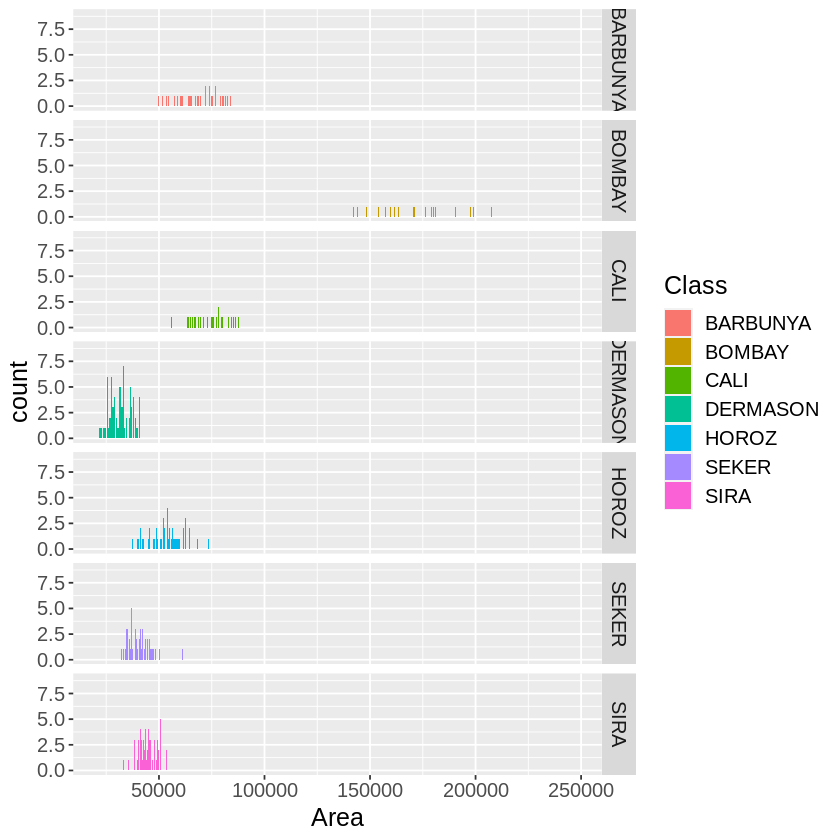

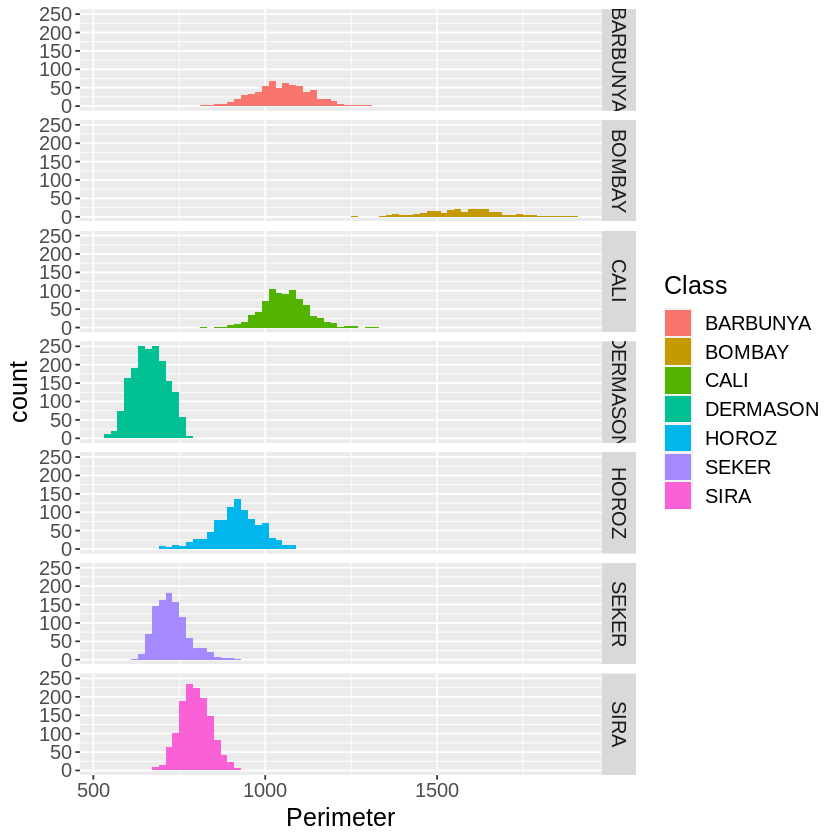

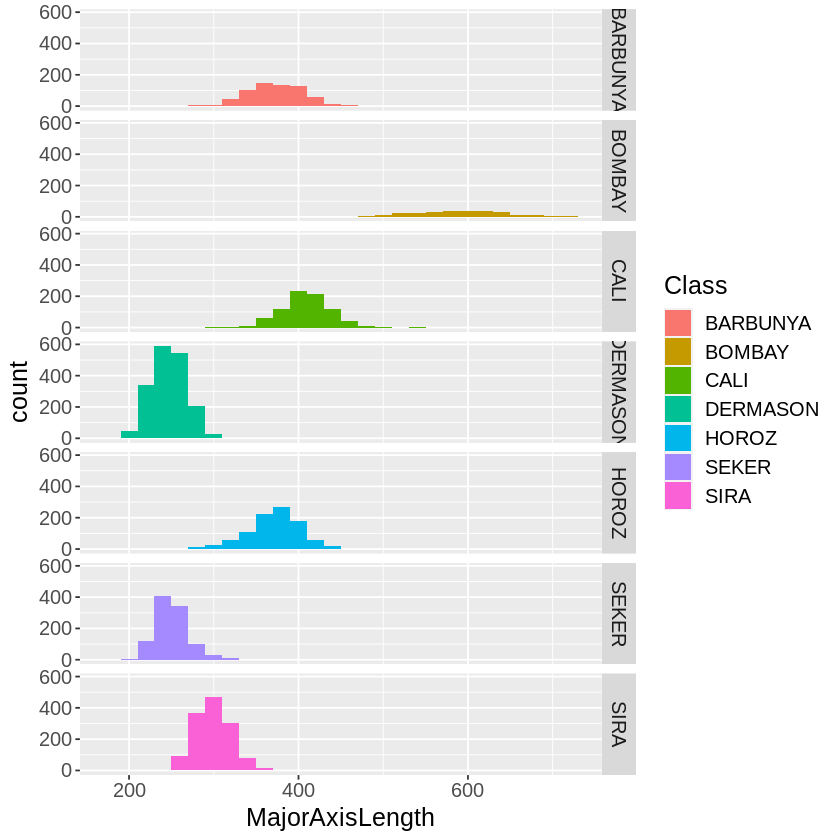

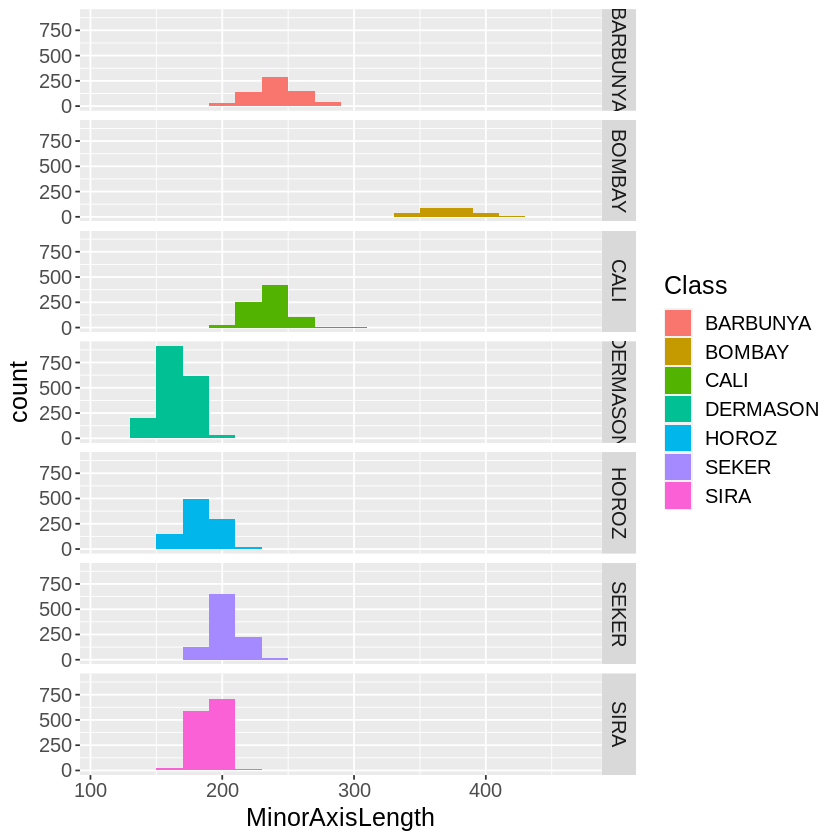

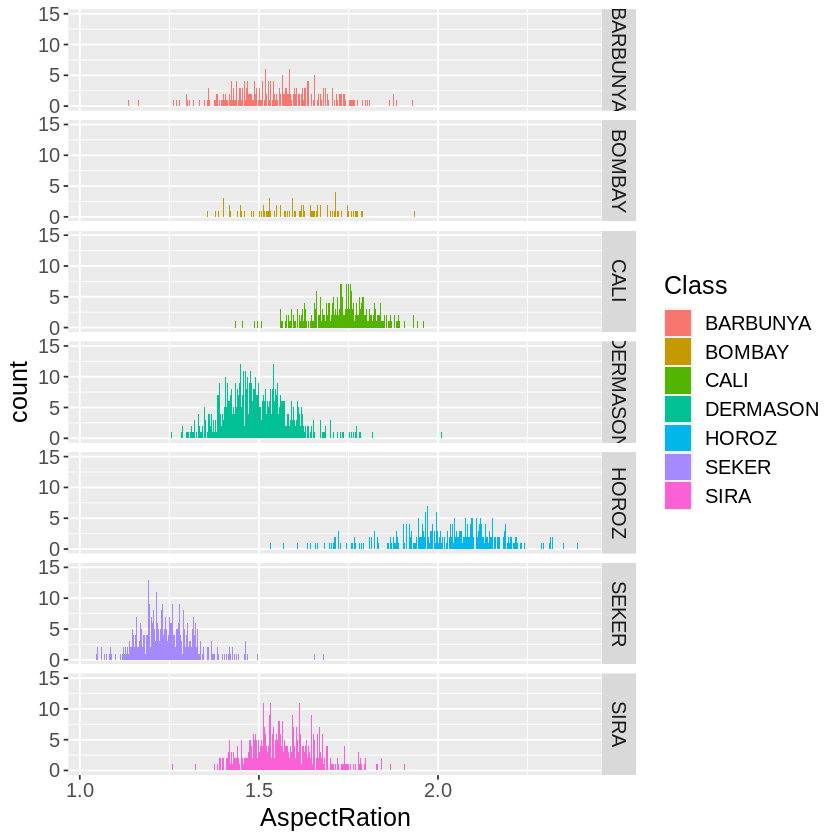

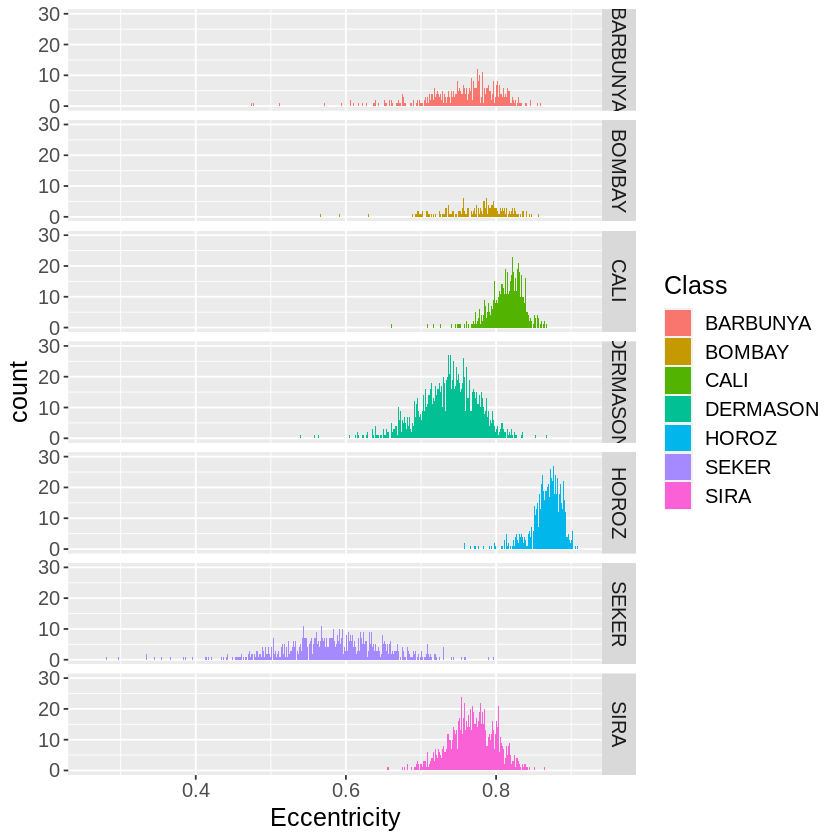

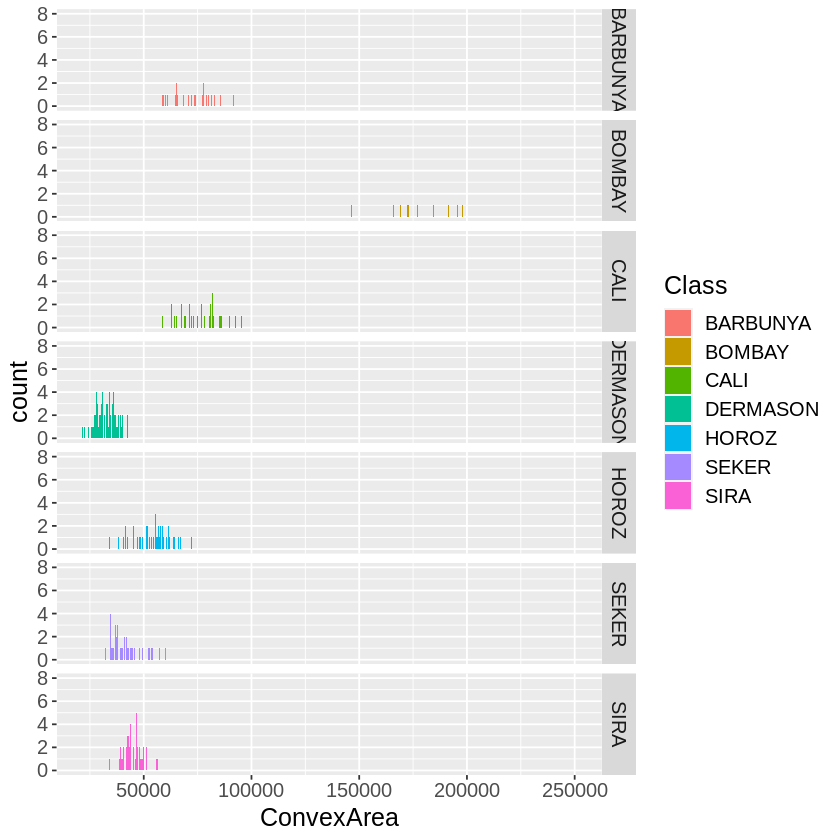

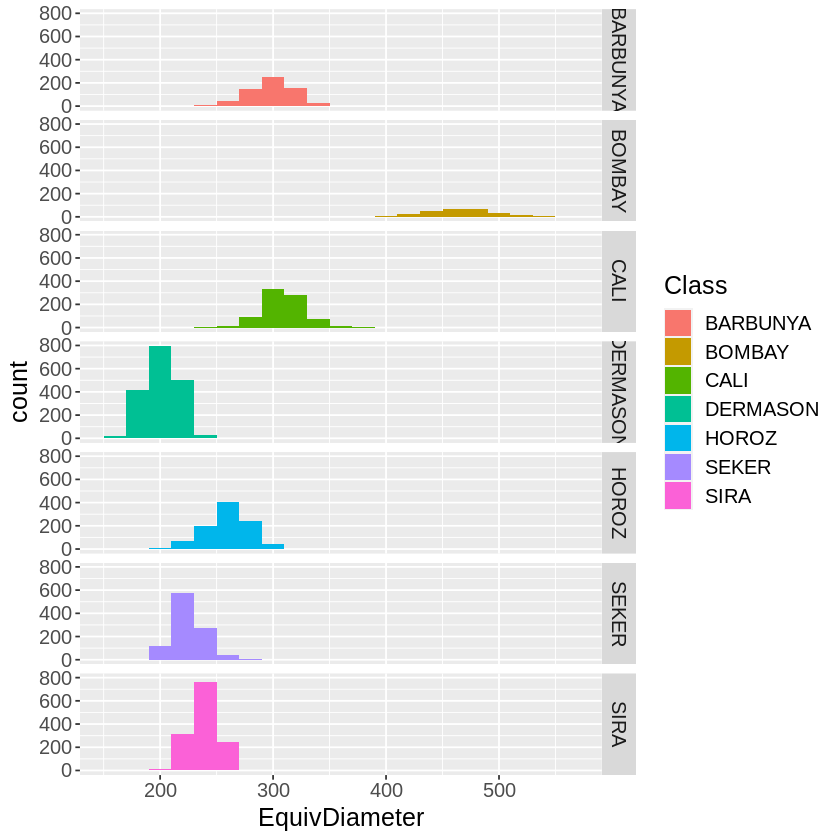

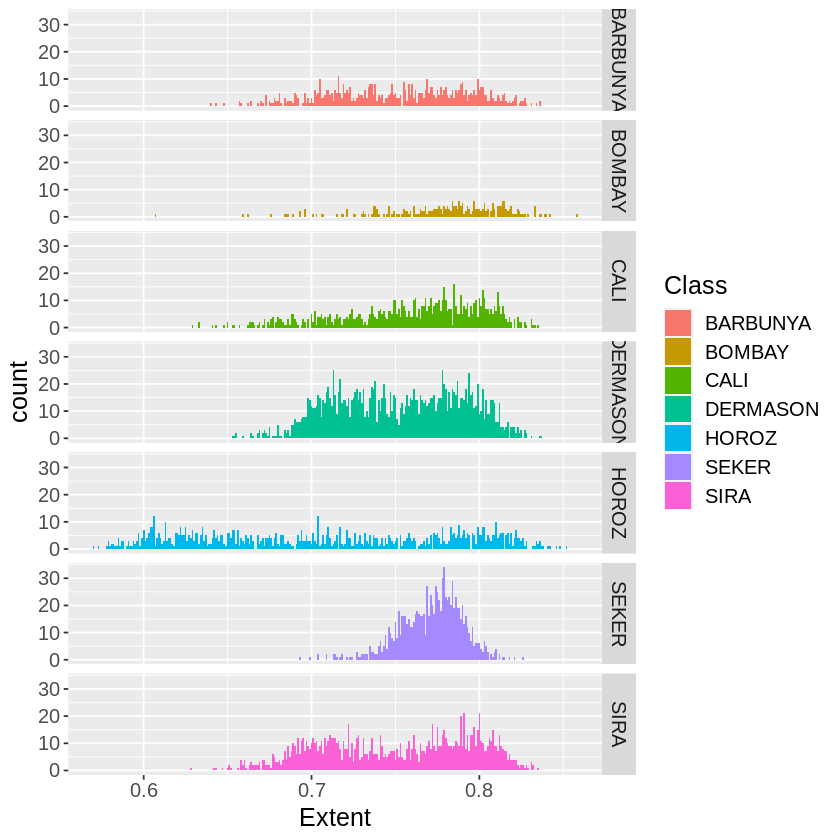

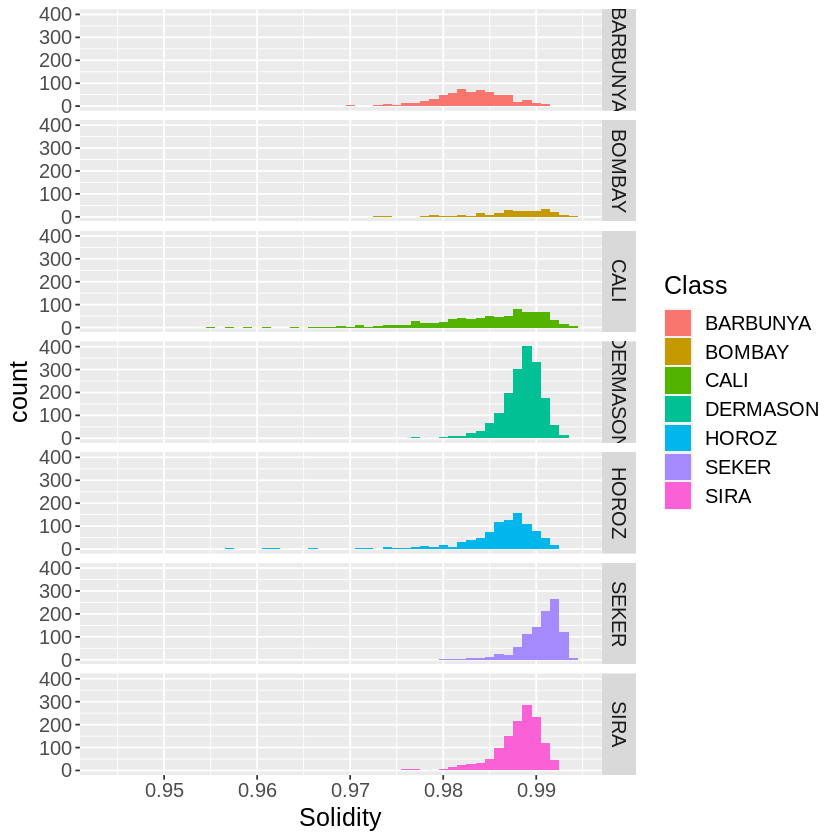

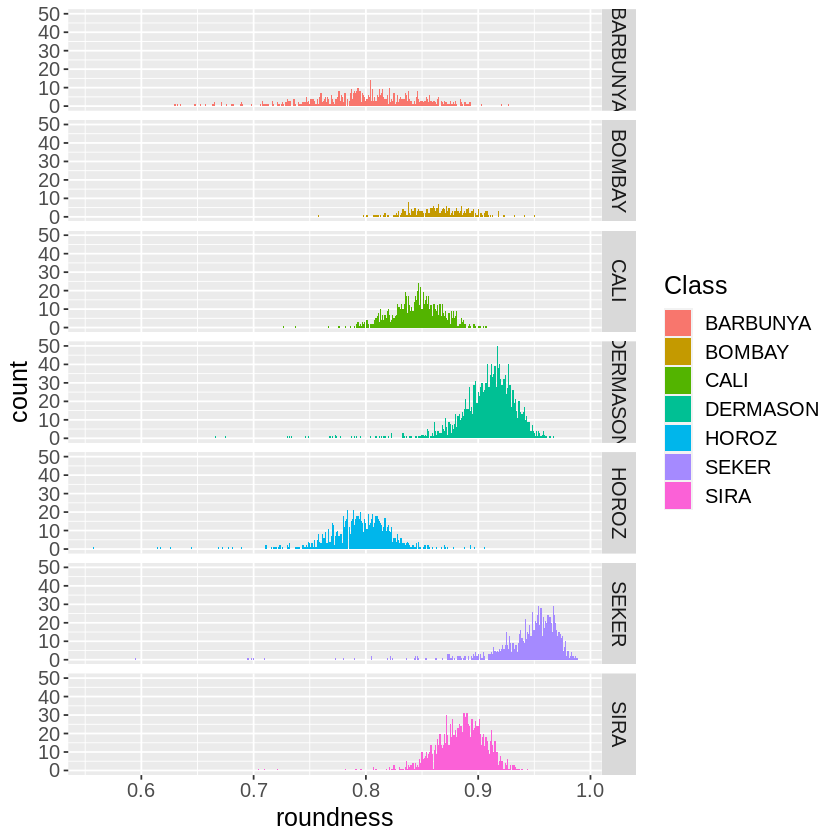

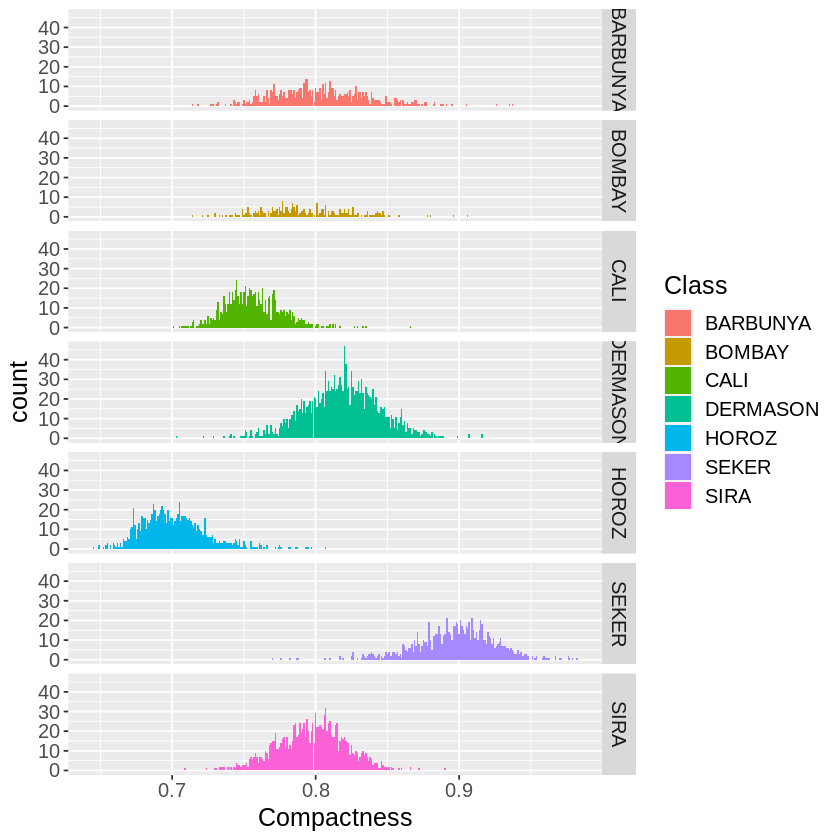

In [9]:

        
bean_area <- bean_train |> 
        ggplot(aes(x= Area, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_2 <- bean_train |> 
        ggplot(aes(x= Perimeter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_3 <- bean_train |> 
        ggplot(aes(x= MajorAxisLength, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_4 <- bean_train |> 
        ggplot(aes(x= MinorAxisLength, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_5 <- bean_train |> 
        ggplot(aes(x= AspectRation, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
bean_eccentricity <- bean_train |> 
        ggplot(aes(x= Eccentricity, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_7 <- bean_train |> 
        ggplot(aes(x= ConvexArea, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_8 <- bean_train |> 
        ggplot(aes(x= EquivDiameter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_9 <- bean_train |> 
        ggplot(aes(x= Extent, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_10 <- bean_train |> 
        ggplot(aes(x= Solidity, fill = Class))+
        geom_histogram(position= "identity",binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_11 <- bean_train |> 
        ggplot(aes(x= roundness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_12 <- bean_train |> 
        ggplot(aes(x= Compactness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))

viz_1
viz_2 
viz_3
viz_4
viz_5
viz_6
viz_7
viz_8
viz_9
viz_10
viz_11
viz_12



# We also specify position = "identity" in geom_histogram to ensure the histograms for each experiment will be
# overlaid side-by-side, instead of stacked bars

### Explanation of graphs

In [10]:
### Add the eplanation here and then convert into a markdown cell

In [14]:
# Train data after the selected predictors
bean_train <- bean_train|>
                        select(Perimeter, AspectRation, Eccentricity, ConvexArea, EquivDiameter, roundness, Compactness, Class)
# Generate summary Statistics of data set. 
bean_train$Class <- factor(bean_train$Class, levels=c("BARBUNYA", "BOMBAY", "CALI", "DERMASON", "HOROZ", "SEKER", "SIRA"))
summary(bean_train )

############## Tableone package ###############

CreateTableOne(data=bean_train) # descriptive table for the entire dataset
table_detail <- CreateTableOne(data=bean_train)
summary(table_detail)

   Perimeter       AspectRation    Eccentricity      ConvexArea    
 Min.   : 530.8   Min.   :1.036   Min.   :0.2628   Min.   : 21057  
 1st Qu.: 702.8   1st Qu.:1.434   1st Qu.:0.7169   1st Qu.: 36588  
 Median : 794.0   Median :1.552   Median :0.7647   Median : 45036  
 Mean   : 855.0   Mean   :1.584   Mean   :0.7513   Mean   : 53760  
 3rd Qu.: 977.8   3rd Qu.:1.710   3rd Qu.:0.8111   3rd Qu.: 62545  
 Max.   :1895.9   Max.   :2.389   Max.   :0.9082   Max.   :251082  
                                                                   
 EquivDiameter     roundness       Compactness          Class     
 Min.   :162.7   Min.   :0.5568   Min.   :0.6454   BARBUNYA: 648  
 1st Qu.:214.7   1st Qu.:0.8329   1st Qu.:0.7617   BOMBAY  : 266  
 Median :238.1   Median :0.8836   Median :0.8011   CALI    : 814  
 Mean   :253.0   Mean   :0.8735   Mean   :0.7996   DERMASON:1762  
 3rd Qu.:279.9   3rd Qu.:0.9166   3rd Qu.:0.8336   HOROZ   : 963  
 Max.   :562.4   Max.   :0.9879   Max.   :0.9816   SEK

                           
                            Overall            
  n                             6804           
  Perimeter (mean (SD))       855.02 (214.44)  
  AspectRation (mean (SD))      1.58 (0.25)    
  Eccentricity (mean (SD))      0.75 (0.09)    
  ConvexArea (mean (SD))    53760.28 (29781.62)
  EquivDiameter (mean (SD))   253.03 (59.26)   
  roundness (mean (SD))         0.87 (0.06)    
  Compactness (mean (SD))       0.80 (0.06)    
  Class (%)                                    
     BARBUNYA                    648 ( 9.5)    
     BOMBAY                      266 ( 3.9)    
     CALI                        814 (12.0)    
     DERMASON                   1762 (25.9)    
     HOROZ                       963 (14.2)    
     SEKER                      1012 (14.9)    
     SIRA                       1339 (19.7)    


     ### Summary of continuous variables ###

strata: Overall
                 n miss p.miss  mean    sd median   p25   p75   min   max  skew
Perimeter     6804    0      0 9e+02 2e+02  8e+02 7e+02 1e+03 5e+02 2e+03  1.62
AspectRation  6804    0      0 2e+00 2e-01  2e+00 1e+00 2e+00 1e+00 2e+00  0.56
Eccentricity  6804    0      0 8e-01 9e-02  8e-01 7e-01 8e-01 3e-01 9e-01 -1.08
ConvexArea    6804    0      0 5e+04 3e+04  5e+04 4e+04 6e+04 2e+04 3e+05  2.91
EquivDiameter 6804    0      0 3e+02 6e+01  2e+02 2e+02 3e+02 2e+02 6e+02  1.94
roundness     6804    0      0 9e-01 6e-02  9e-01 8e-01 9e-01 6e-01 1e+00 -0.59
Compactness   6804    0      0 8e-01 6e-02  8e-01 8e-01 8e-01 6e-01 1e+00  0.05
               kurt
Perimeter      3.50
AspectRation   0.09
Eccentricity   1.44
ConvexArea    10.42
EquivDiameter  5.09
roundness      0.16
Compactness   -0.22


     ### Summary of categorical variables ### 

strata: Overall
   var    n miss p.miss    level freq percent cum.percent
 Class 6804  

### Explanation of summary table


### Forward selection

In [ ]:
# # select all columns (possible predictors) except Class
# names <- colnames(bean_train |> select (-Class))

# # Make model formula for all predictors
# model_formula <- paste("Class", "~", paste(names, collapse="+"))
# model_formula 

# # create an empty tibble to store the results
# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# # create a model specification
# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) |>
#      set_engine("kknn") |>
#      set_mode("classification")

# # create a 5-fold cross-validation object
# BeanData_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# # store the total number of predictors
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

In [ ]:
# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         BeanData_recipe <- recipe(as.formula(model_string), 
#                                 data = bean_train) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

#         # tune the KNN classifier with these predictors, 
#         # and collect the accuracy for the best K
#         acc <- workflow() |>
#           add_recipe( BeanData_recipe ) |>
#           add_model(knn_spec) |>
#           tune_grid(resamples = BeanData_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies |> 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }
# accuracies

In [ ]:
#THIS CODE IS FOR FINDING THE OPTIMAL VALUE OF K FOR OUR SELECTED MODEL

set.seed(2020) # DO NOT REMOVE
# standarization recipe

bean_recipe <- recipe(Class ~., data = bean_refined_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
      set_mode("classification")

# cross validation

bean_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# Assemble into workflow
knn_results <- workflow() |>
       add_recipe(bean_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = bean_vfold, grid = 10) |>
       collect_metrics()

knn_results

In [ ]:

# find best value of number of K
accuracies <- knn_results |> 
       filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracies
accuracy_versus_k

# the highest accuracy is 91.12 and it is found at K=12
highest_accuracy <- accuracies|> select(neighbors, mean)|> arrange(desc(mean))
highest_accuracy

###### 